In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization

In [ ]:
# --- INÍCIO DO SCRIPT DE TESTE ---

# 1. Carregar o Banco de Dados (California Housing)
print("1. Carregando o banco de dados...")
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target)

# 2. Dividir os dados em Conjunto de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- OTIMIZAÇÃO PARA LIGHTGBM ---
print("="*50)
print("INICIANDO OTIMIZAÇÃO PARA LIGHTGBM")
print("="*50)

space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 700),
    Integer(name='max_depth', low = 200, high = 700),
    Real(name='feature_fraction', low = 0.5 , high = 1),
    Real(name='bagging_fraction', low = 0.7 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.5, high = 1)
]

fixed_params_lgbm = {
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 300,
    'random_state': 42, 
    'n_jobs': -1, 
    'verbose': -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=10, verbose=False)]}
optimization_kwargs = {'n_initial_points': 5,
                        'n_calls': 10,
                        'initial_point_generator': 'lhs',
                        'random_state': 42,

                       
                       }

# Simplesmente passe 'model_type="lightgbm"'
optimizer_lgbm = RunOptimization()
results=optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=[X_train, X_test, y_train, y_test],
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs

)

optimizer_lgbm.optimizer[0].fit_best_model()

1. Carregando o banco de dados...
INICIANDO OTIMIZAÇÃO PARA LIGHTGBM
Optimization finished.
Best score (mean_absolute_error): 0.2818
Best parameters: {'learning_rate': 0.08032145496250154, 'num_leaves': np.int64(594), 'max_depth': np.int64(667), 'feature_fraction': 0.7414033489099505, 'bagging_fraction': 1.0, 'bagging_freq': np.int64(1), 'lambda_l1': 0.9148060866796668, 'lambda_l2': 0.5}

To train the final model with these parameters, call the '.fit_best_model()' method.
Training the final model with the best parameters...
Final model has been trained and is stored in the '.best_model_' attribute.


In [3]:
print(f"\nMelhor MAE para LightGBM: {results[0].fun:.4f}")
print(f"Melhores parâmetros: {results[0].x}")

print(optimizer_lgbm.optimizer[0].X_test)
print(optimizer_lgbm.optimizer[0].y_test)
print(optimizer_lgbm.optimizer[0].y_test)

print(type(optimizer_lgbm.optimizer[0].X_test))
print(type(optimizer_lgbm.optimizer[0].y_test))
print(type(optimizer_lgbm.optimizer[0].y_pred))


Melhor MAE para LightGBM: 0.2818
Melhores parâmetros: [0.08032145496250154, np.int64(594), np.int64(667), 0.7414033489099505, 1.0, np.int64(1), 0.9148060866796668, 0.5]
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
20046  1.6812      25.0  4.192201   1.022284      1392.0  3.877437     36.06   
3024   2.5313      30.0  5.039384   1.193493      1565.0  2.679795     35.14   
15663  3.4801      52.0  3.977155   1.185877      1310.0  1.360332     37.80   
20484  5.7376      17.0  6.163636   1.020202      1705.0  3.444444     34.28   
9814   3.7250      34.0  5.492991   1.028037      1063.0  2.483645     36.62   
...       ...       ...       ...        ...         ...       ...       ...   
15362  4.6050      16.0  7.002212   1.066372      1351.0  2.988938     33.36   
16623  2.7266      28.0  6.131915   1.256738      1650.0  2.340426     35.36   
18086  9.2298      25.0  7.237676   0.947183      1585.0  2.790493     37.31   
2144   2.7850      36.0  5.289

In [5]:
parameters_run_model = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 30,
    "max_depth": 7,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "force_row_wise": True,
    "verbosity": -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=10, verbose=False)]}

# Simplesmente passe 'model_type="lightgbm"'
lgbm_model = RunModel()
results=lgbm_model.run(
    model_class="lgbm",
    datasets=[X_train, X_test, y_train, y_test],
    params=parameters_run_model,
    calibration_kwargs= calibration_kwargs
)

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
print(type(lgbm_model.models))
print(type(lgbm_model.models[0]))
print(type(results))
print(type(results[0]))
y_pred=lgbm_model.models[0].predict(results[0])

print(type(y_pred))
print(y_pred)

<class 'list'>
<class 'modules.models.LGBMTrainning'>
<class 'list'>
<class 'lightgbm.basic.Booster'>
<class 'numpy.ndarray'>
[0.49308831 0.88583469 4.62602639 ... 5.04322149 0.74325382 1.62495011]


In [ ]:
# # Agora, para otimizar outro modelo, só mudamos o tipo e os parâmetros!
# optimizer_xgb = BayesianOptimization(
#     model_type="xgboost",
#     X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
#     space=space_xgb, fixed_params=fixed_params_xgb
# )
# resultado_xgb = optimizer_xgb.run(n_calls=15, random_state=42)
# print(f"\nMelhor MAE para XGBoost: {resultado_xgb.fun:.4f}")
# print(f"Melhores parâmetros: {resultado_xgb.x}")

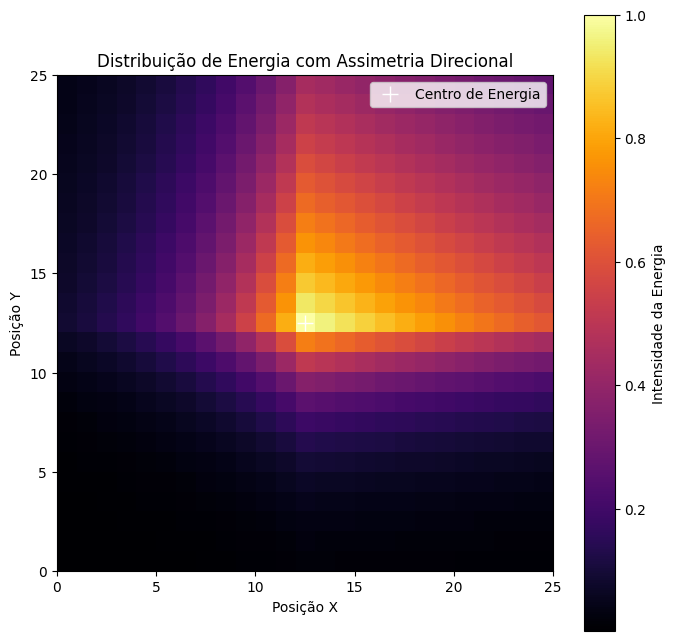

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensão do grid
N = 25
data = np.zeros((N, N))

# Definir célula central (meio do grid)
cx, cy = N//2, N//2

# --- CONTROLE DA ASSIMETRIA ---
# Altere estes valores para controlar a rapidez com que a energia decai em cada direção.
# Valores maiores = decaimento mais lento (energia se espalha mais).
# Valores menores = decaimento mais rápido (energia mais concentrada).
decay_x_positivo = 25.0 # Direita
decay_x_negativo = 5.0  # Esquerda
decay_y_positivo = 15.0 # Cima
decay_y_negativo = 3.0  # Baixo


# Irradiação de energia
for i in range(N):
    for j in range(N):
        # CORREÇÃO: dx é a distância horizontal (colunas, j) e dy é a vertical (linhas, i)
        dx_abs = abs(j - cx)
        dy_abs = abs(i - cy)

        # Determina o fator de decaimento em X com base na posição horizontal (j)
        if j >= cx:
            decay_x = decay_x_positivo
        else:
            decay_x = decay_x_negativo

        # Determina o fator de decaimento em Y com base na posição vertical (i)
        if i >= cy:
            decay_y = decay_y_positivo
        else:
            decay_y = decay_y_negativo
            
        # Calcula a energia com os decaimentos direcionais corretos
        # Adicionamos uma pequena constante (1e-9) para evitar divisão por zero se o decaimento for 0
        energia = np.exp(-(dx_abs / (decay_x + 1e-9) + dy_abs / (decay_y + 1e-9)))
        data[i, j] = energia

# Plotar o grid como mapa de calor
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap="inferno", origin="lower", extent=[0, N, 0, N])
plt.colorbar(label="Intensidade da Energia")
plt.title("Distribuição de Energia com Assimetria Direcional")
plt.xlabel("Posição X")
plt.ylabel("Posição Y")

# Adicionar uma marcação no centro
plt.plot(cx + 0.5, cy + 0.5, 'w+', markersize=12, label='Centro de Energia')
plt.legend()
plt.grid(False)
plt.show()

